# Task for Today  

***

## Legendary Pokémon Classification  

Use a FeedForward Neural Network to predict if a given Pokémon is **legendary** or not, based on *Pokémon features*.


<img src="https://wallpapers.com/images/hd/legendary-pokemon-pictures-7yo7x0f1l2b2tu0r.jpg" width="800" height="500" alt="legendaries">

Data available at: https://gist.github.com/armgilles/194bcff35001e7eb53a2a8b441e8b2c6

Download the zip file, extract it and put the `pokemon.csv` file in the file section of colab.

# Challenge

TAs want to battle!

<img src="https://pokemongohub.net/wp-content/uploads/2023/06/grunts-1.jpg" width="400" height="300" alt="TAs">

Rules of the challenge:

- Gotta catch 'em all! ...But give priority to the legendaries.
- F1-score is usually the measure of choice for imbalanced datasets; however in this case we particularly want to avoid not "catching" legendaries. They're so rare, you might not have any more chances to catch 'em if they flee...
- In ML terms, we give recall more importance than precision for the task (check the whiteboard if you don't know their meaning).
- F2-score (i.e., [F-$\beta$-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html) with $\beta = 2$) is hence used as the main evaluation metric for your model.

- **TAs achieved a F2-score of 0.7692. Can you beat them?!**

# Imports and dataset

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.optim as optim

In [34]:
_ = torch.manual_seed(42) # for a fair comparison, don't change the seed!

In [35]:
data = pd.read_csv('pokemon.csv')

In [36]:
data

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True


In [37]:
data_raw = data.copy() # usually, if memory allows it, it's a good idea to keep a raw version of your data

# Pre-processing / encoding

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


In [39]:
data.isna().sum()

#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

In [40]:
data = data.drop(['#', 'Name', 'Type 2'], axis=1)
# dropping type 2 is actually a debeatable step, it may provide useful information
# data = data.drop(["#", "Name"], axis=1)

In [41]:
data['Legendary'] = data['Legendary'].astype(int)

In [42]:
data.dtypes

Type 1        object
Total          int64
HP             int64
Attack         int64
Defense        int64
Sp. Atk        int64
Sp. Def        int64
Speed          int64
Generation     int64
Legendary      int64
dtype: object

Categorical variables are one-hot encoded

In [43]:
def onehot_encode(df, column, prefix):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [44]:
data = onehot_encode(data, 'Type 1', 't')
data = onehot_encode(data, 'Generation', 'g')

In [45]:
data.shape

(800, 32)

## Splitting and Scaling

In [46]:
data.columns # note that only the first 7 features are continuous now

Index(['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed',
       'Legendary', 't_Bug', 't_Dark', 't_Dragon', 't_Electric', 't_Fairy',
       't_Fighting', 't_Fire', 't_Flying', 't_Ghost', 't_Grass', 't_Ground',
       't_Ice', 't_Normal', 't_Poison', 't_Psychic', 't_Rock', 't_Steel',
       't_Water', 'g_1', 'g_2', 'g_3', 'g_4', 'g_5', 'g_6'],
      dtype='object')

In [47]:
y = data['Legendary']
X = data.drop('Legendary', axis=1)

In [48]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X.iloc[:,:7])
X = np.concatenate((X_scaled, np.array(X.iloc[:,7:])), axis=1)

In [49]:
train_size = 0.6
valid_size = 0.4
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, train_size=valid_size, random_state=42)

y_train.shape, y_valid.shape, y_test.shape # end split is 60,16,24

((480,), (128,), (192,))

# Model definition

In [50]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [51]:
import copy

class EarlyStopping():
  def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
    self.patience = patience
    self.min_delta = min_delta # minimum improvement to reset patience
    self.restore_best_weights = restore_best_weights
    self.best_model = None
    self.best_loss = None
    self.counter = 0
    self.status = ""

  def __call__(self, model, val_loss):
    if self.best_loss is None:
      self.best_loss = val_loss
      self.best_model = copy.deepcopy(model)
    elif self.best_loss - val_loss > self.min_delta:
      self.best_loss = val_loss
      self.counter = 0
      self.best_model.load_state_dict(model.state_dict())
    elif self.best_loss - val_loss < self.min_delta:
      self.counter += 1
      if self.counter >= self.patience:
        self.status = f"Stopped on {self.counter}"
        if self.restore_best_weights:
          model.load_state_dict(self.best_model.state_dict())
        return True
    self.status = f"{self.counter}/{self.patience}"
    return False


### Define your model :

Choose yourself in the model:
- number of hidden layers
- number of neurons per layer (careful with input and output, these are not a choice)
- activation functions
- any other possible component among those seen so far in theory.

In [52]:
class is_legendary(nn.Module):
    def __init__(self, input_size, output_size = 1):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, output_size)
        )

    def forward(self, x):
        output = nn.functional.sigmoid(self.linear_relu_stack(x))
        return output

Instantiate your model and print it out

In [53]:
model = is_legendary(X.shape[1]).to(device)
early_stop = EarlyStopping(patience=5)
print(model)

is_legendary(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=31, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)


### Hyperparameters:

Choose carefully your:
- learning rate (this is usually the most important hyperparameter to get right, but some optimizers are more forgiving than others)
- batch size
- number of epochs.
- other hyperparameters that you might need

In [54]:
learning_rate = 0.003
batch_size = 16
epochs = 100

### Loss function and optimizer:

- What's the appropriate loss function for the task?
- Decide which optimizer you want to use ([Documentation](https://pytorch.org/docs/stable/optim.html))

In [55]:
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.95) #, weight_decay=1e-5)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

Define your TensorDatasets and DataLoaders; remember to use the appropriate dtype for your tensors.

In [56]:
trainset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                          torch.tensor(y_train.values, dtype=torch.float32))
validset = torch.utils.data.TensorDataset(torch.tensor(X_valid, dtype=torch.float32),
                                         torch.tensor(y_valid.values, dtype=torch.float32))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


In [57]:
train_loss_list = []
valid_loss_list = []

train_length = len(trainloader)
valid_length = len(validloader)

In [58]:
for epoch in range(epochs):  # loop over the dataset multiple times

    train_loss = 0.
    valid_loss = 0.

    model.train()
    for batch, (inputs, labels) in enumerate(trainloader):
        # make sure both inputs and labels are on the proper device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(torch.squeeze(outputs), labels)

        loss.backward()
        optimizer.step()

        # keep track of the training loss
        train_loss += loss.item()
    train_loss_list.append(train_loss/train_length)

    model.eval()
    with torch.no_grad():
      for inputs, labels in validloader:
        # make sure both inputs and labels are on the proper device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward and loss calculation (no backward, no optimizer)
        outputs = model(inputs)
        loss = criterion(torch.squeeze(outputs), labels)

        # keep track of the validation loss
        valid_loss += loss.item()

    valid_loss_list.append(valid_loss/valid_length)

    # scheduler.step(valid_loss)

    # print out training and validation loss
    if epoch % 10 == 0:
      print(f'Epoch: {epoch}\t Train loss: {(train_loss/train_length):.10f}')
      print(f'Epoch: {epoch}\t Valid loss: {(valid_loss/valid_length):.10f}')

    # Early stopping check
    if early_stop(model, valid_loss/valid_length):
      print(f"Stopped trained at epoch {epoch}")
      break

print('Finished Training')

Epoch: 0	 Train loss: 0.5636271616
Epoch: 0	 Valid loss: 0.4734439142
Epoch: 10	 Train loss: 0.1653412915
Epoch: 10	 Valid loss: 0.1456801912
Epoch: 20	 Train loss: 0.1082902922
Epoch: 20	 Valid loss: 0.1011964646
Epoch: 30	 Train loss: 0.0962532042
Epoch: 30	 Valid loss: 0.1050666193
Stopped trained at epoch 30
Finished Training


# Results

### Plotting

Plot out the training and validation losses over the epochs

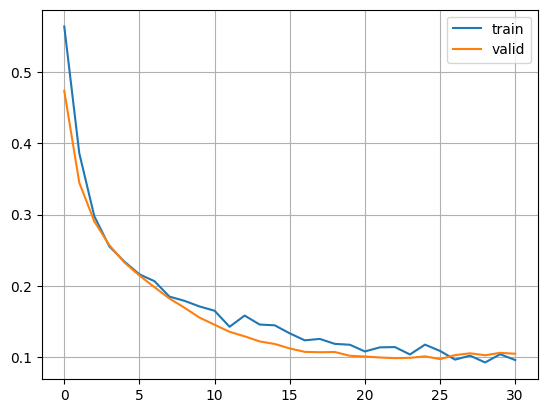

In [59]:
plt.plot(np.arange(len(train_loss_list)), train_loss_list, label='train')
plt.plot(np.arange(len(valid_loss_list)), valid_loss_list, label='valid')
plt.legend(loc="best")
plt.grid("on")
plt.show()

### Metrics

Print out appropriate metrics for the task

In [60]:
from sklearn.metrics import accuracy_score, confusion_matrix, fbeta_score, classification_report

with torch.no_grad():
  model.eval()
  pred = model(torch.from_numpy(X_test).to(device).to(torch.float32))
  pred_classes = (pred >= 0.5).to(torch.float32)
  confusion = confusion_matrix(y_test.values,pred_classes.cpu())
  print(f"Confusion matrix: \n{confusion} \n\n")
  f2 = fbeta_score(y_test.values,pred_classes.cpu(),beta=2)
  print(f"F2-Score: {round(f2,4)}\n\n")
  report = classification_report(y_test.values,pred_classes.cpu())
  print(f"Classification report:\n{report}")

Confusion matrix: 
[[175   8]
 [  1   8]] 


F2-Score: 0.7692


Classification report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       183
           1       0.50      0.89      0.64         9

    accuracy                           0.95       192
   macro avg       0.75      0.92      0.81       192
weighted avg       0.97      0.95      0.96       192



In [61]:
wrong_predictions = pred_classes.squeeze().cpu().numpy() != y_test.values

In [62]:
mislabeled_indices = y_test[wrong_predictions].index

In [63]:
data_raw.loc[mislabeled_indices,:]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
306,282,GardevoirMega Gardevoir,Psychic,Fairy,618,68,85,65,165,135,100,3,False
409,373,SalamenceMega Salamence,Dragon,Flying,700,95,145,130,120,90,120,3,False
165,151,Mew,Psychic,NaN,600,100,100,100,100,100,100,1,False
493,445,Garchomp,Dragon,Ground,600,108,130,95,80,85,102,4,False
248,229,HoundoomMega Houndoom,Dark,Fire,600,75,90,90,140,90,115,2,False
196,181,AmpharosMega Ampharos,Electric,Dragon,610,90,95,105,165,110,45,2,False
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True
7,6,CharizardMega Charizard X,Fire,Dragon,634,78,130,111,130,85,100,1,False
494,445,GarchompMega Garchomp,Dragon,Ground,700,108,170,115,120,95,92,4,False


The only legendary we didn't catch is Diancie! :(

Notice how the errors are mostly some extreme versions of pokemons, which indeed look legendary.  

Not sure why Mew isn't legendary, but our model (and the TAs) thought it was!

Did you manage to catch them all?

______________________________________________________________________________

This notebook is largely inspired (with some improvements) by a video featured on [Data Every Day](https://www.youtube.com/watch?v=3Fr1npNxkJk).